Banana Data: Since classes are ordinal, I used an ordinal regression to fit then showed how most important features for the model appear on line chart.

Top version keeps all data, bottom version removes columns with less than 50% data

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_32828\1443452081.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20), palette='coolwarm')


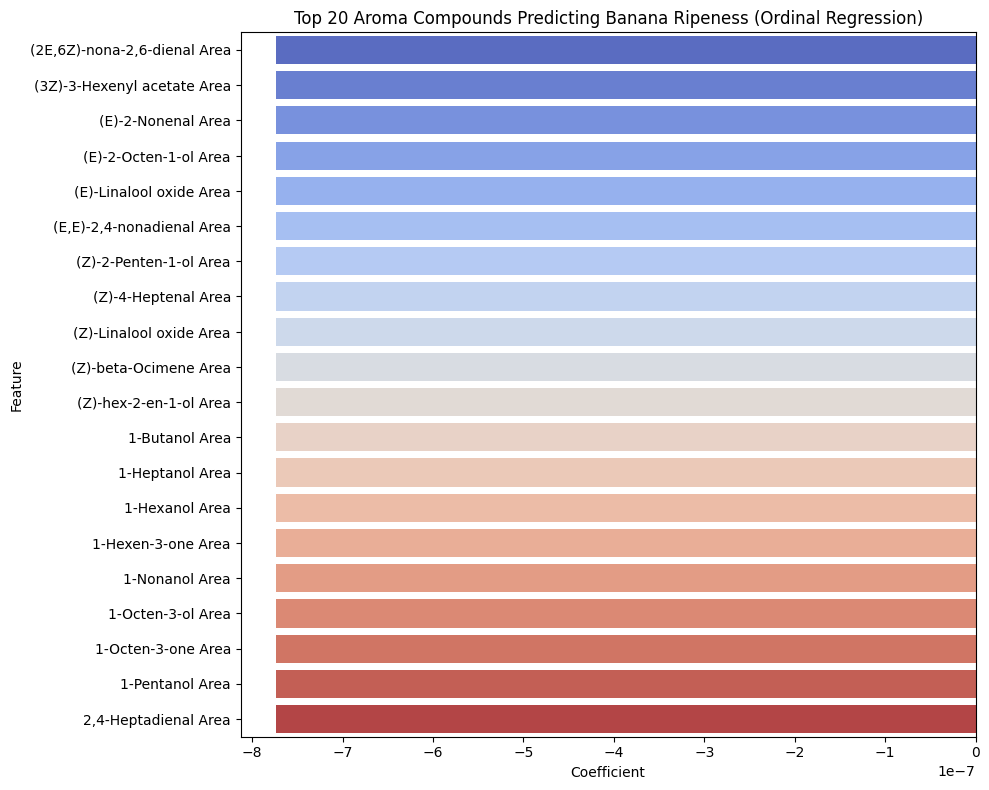

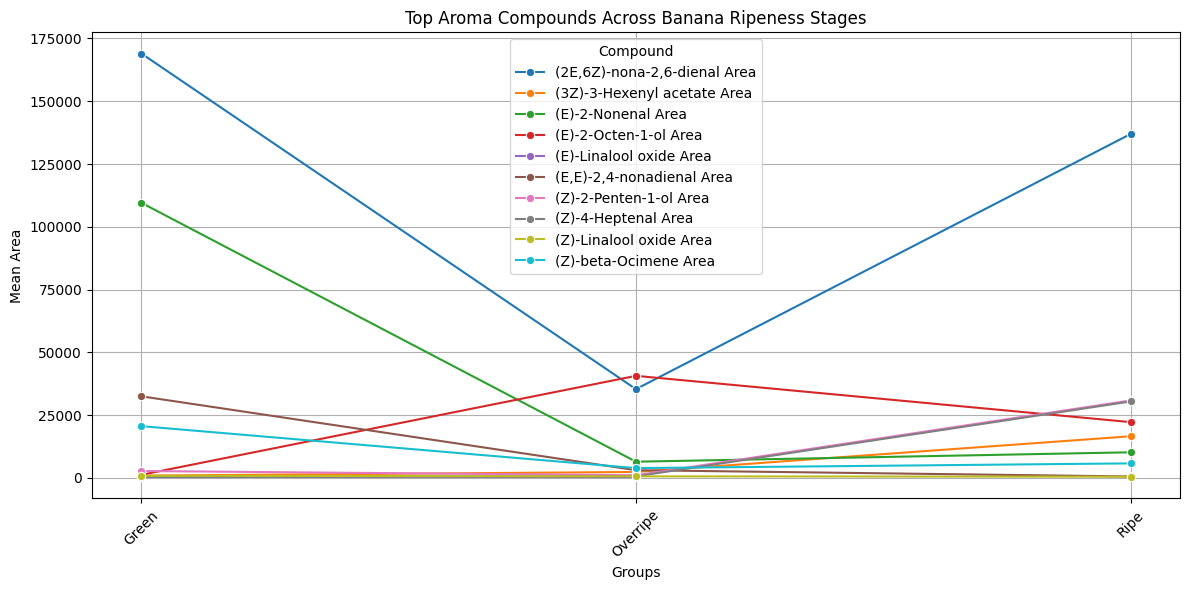

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from mord import LogisticAT  # Ordinal regression model

# Load the dataset
df = pd.read_csv("badata.csv")

# Drop the first unnamed column if it's an index
df = df.drop(columns=[df.columns[0]])

# Remove columns with more than 50% missing values
threshold = 0.5
missing_ratio = df.isnull().mean()
filtered_df = df.loc[:, missing_ratio < threshold]

# Separate features and target
target = filtered_df['Groups']
features = filtered_df.drop(columns=['Groups'])

# Encode the target as ordinal: Green < Ripe < Overripe
ordinal_map = {'Green': 0, 'Ripe': 1, 'Overripe': 2}
y = target.map(ordinal_map).values

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(features)

# Fit ordinal regression model
model = LogisticAT()
model.fit(X, y)

# Get feature coefficients
coefficients = model.coef_[0]
feature_names = features.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plot top 20 contributing features
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20), palette='coolwarm')
plt.title('Top 20 Aroma Compounds Predicting Banana Ripeness (Ordinal Regression)')
plt.tight_layout()
plt.savefig("ordinal_top_features.png")
plt.show()



# Select top 10 contributing features
top_features = coef_df.head(10)['Feature'].values

# Calculate mean values of top features grouped by ripeness
grouped_means = df.groupby('Groups')[top_features].mean().reset_index()

# Melt the dataframe for plotting
melted_df = grouped_means.melt(id_vars='Groups', var_name='Compound', value_name='Mean Area')

# Plot lineplot showing how compound levels change across ripeness stages
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.title('Top Aroma Compounds Across Banana Ripeness Stages')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("top_compounds_lineplot.png")
plt.show()

Above (remove columns with more than 50% missing values):
Below (no removal of columns):


Interestingly, only difference is 2-Pentenal area

Importantly, this suggests that the most predictive compounds are well-measured across all samples. It also suggests features with missing value were not contributing much to the ordinal regression model (robustness)

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_32828\3533737846.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20), palette='coolwarm')


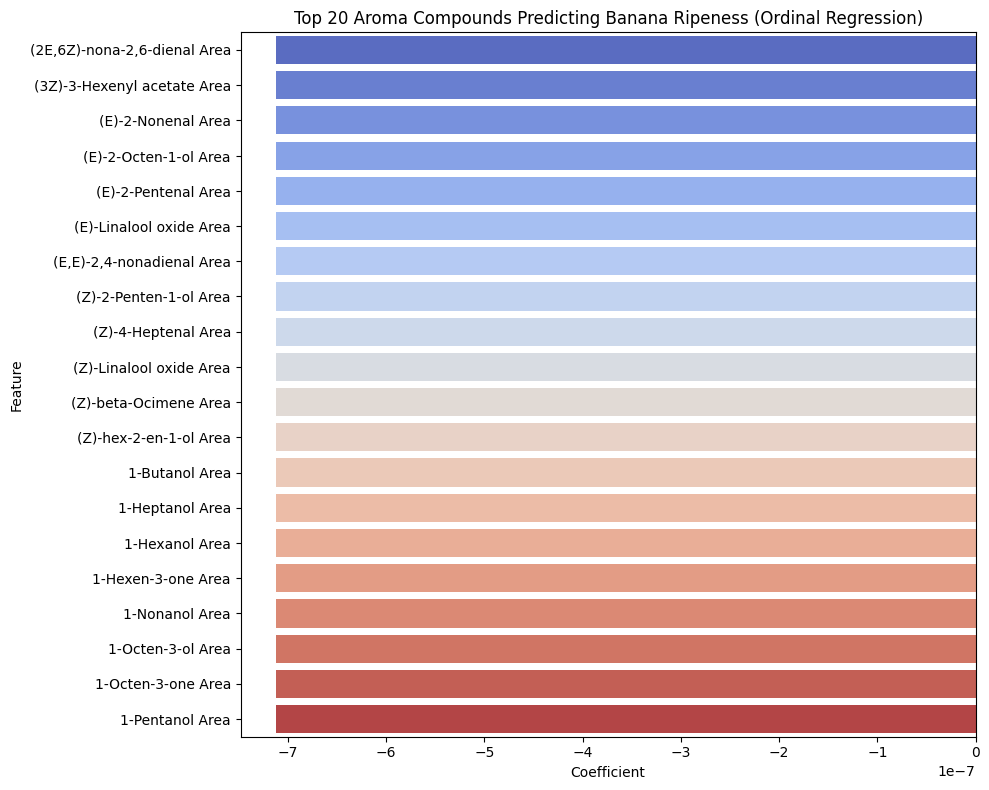

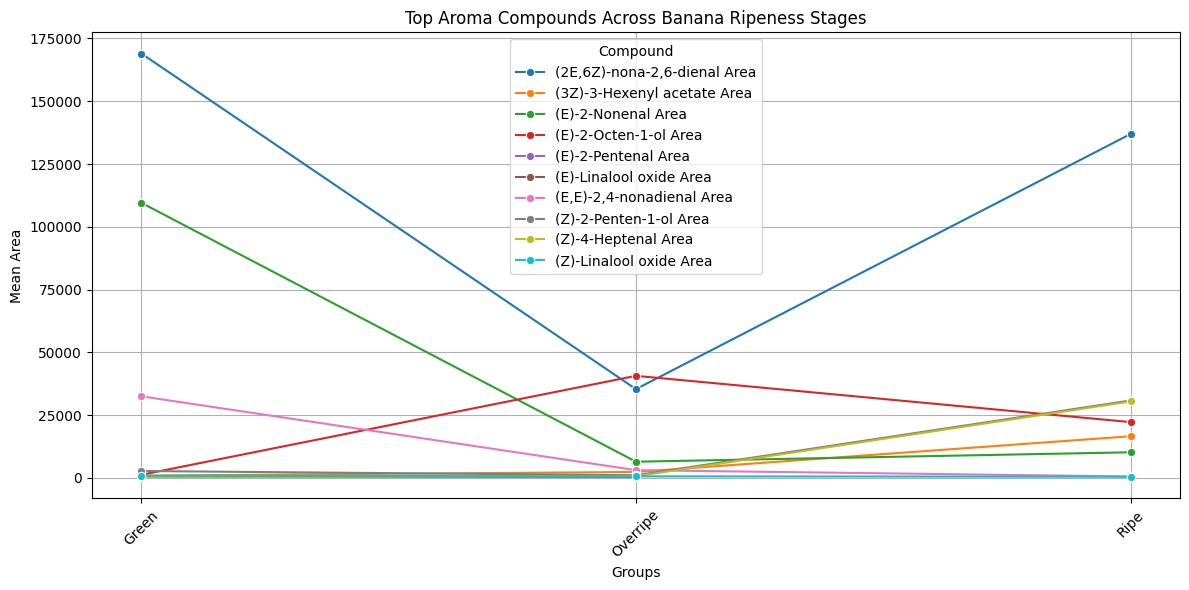

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from mord import LogisticAT  # Ordinal regression model

# Load the dataset
df = pd.read_csv("badata.csv")

# Drop the first unnamed column if it's an index
df = df.drop(columns=[df.columns[0]])


# Separate features and target
target = df['Groups']
features = df.drop(columns=['Groups'])

# Encode the target as ordinal: Green < Ripe < Overripe
ordinal_map = {'Green': 0, 'Ripe': 1, 'Overripe': 2}
y = target.map(ordinal_map).values

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(features)

# Fit ordinal regression model
model = LogisticAT()
model.fit(X, y)

# Get feature coefficients
coefficients = model.coef_[0]
feature_names = features.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plot top 20 contributing features
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20), palette='coolwarm')
plt.title('Top 20 Aroma Compounds Predicting Banana Ripeness (Ordinal Regression)')
plt.tight_layout()
plt.savefig("ordinal_top_features.png")
plt.show()


# Select top 10 contributing features
top_features = coef_df.head(10)['Feature'].values

# Calculate mean values of top features grouped by ripeness
grouped_means = df.groupby('Groups')[top_features].mean().reset_index()

# Melt the dataframe for plotting
melted_df = grouped_means.melt(id_vars='Groups', var_name='Compound', value_name='Mean Area')

# Plot lineplot showing how compound levels change across ripeness stages
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.title('Top Aroma Compounds Across Banana Ripeness Stages')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("top_compounds_lineplot.png")
plt.show()
